In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import pandas_ta as ta
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import *
from neuralforecast.auto import *
from neuralforecast.losses.pytorch import MQLoss


In [2]:
exportPath = './exports/'
marketPath = './'
imgPath = './exports/img/'
modelPath = './exports/model/'

In [3]:
def log_transform(df):
    # copy the dataframe
    tdf = df.copy()
    # apply log scaling
    for column in tdf.columns:
        tdf[column] = np.log(tdf[column])
    tdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    tdf = tdf.astype(float)
    tdf = tdf.interpolate(method='linear', axis=0).ffill().bfill()
    tdf = tdf.fillna(0)
    return tdf

def boxcox(df):
    # copy the dataframe
    _df = df.copy()
    # apply log scaling
    for column in _df.columns:
        _df[column] = boxcox1p(_df[column], 0.25)
    _df = _df.fillna(0)
    _df = _df.astype(float)
    return _df

def min_max_scaling(df):
    # copy the dataframe
    tdf = df.copy()
    # apply min-max scaling
    for column in tdf.columns:
        tdf[column] = (tdf[column] - tdf[column].min()) / (tdf[column].max() - tdf[column].min())
    tdf = tdf.fillna(0)
    return tdf


# --------------------------------------------------------------------------------------------------------------------------------------------

2013-12-27 2022-11-19


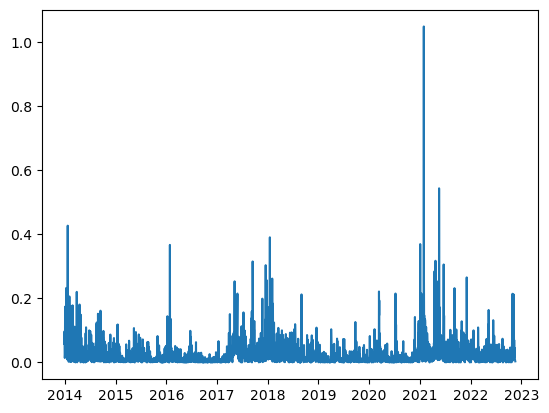

In [4]:
ticker = 'DOGE'

_df = pd.read_csv(marketPath + ticker + '_Data.csv',parse_dates = True,index_col=0)
_df = log_transform(_df)
# plt.plot(_df)


# HRV: Heart rate variability - RMSSD: Root mean square of the successive differences

def rmssd(data):
    delta = data.shift(0) - data.shift(1) 
    delta *= delta
    return np.sqrt(delta / 2)

def lnrmssd(data):
    delta = data.shift(0) - data.shift(1) 
    delta *= delta
    return np.log(np.sqrt(delta / 2))


rmssd_data = ta.sma(rmssd(_df.low), 1).rename("rmssd")
lnrmssd_data = ta.sma(lnrmssd(_df.low), 1).rename("lnrmssd")

plt.plot(rmssd_data)
# plt.plot(lnrmssd_data)

macd = ta.macd(_df['close'])
stochrsi = ta.stochrsi(_df['close'])




_df = pd.concat(
    [
        _df, 
        rmssd_data, 
        lnrmssd_data,
        macd, 
        stochrsi
    ],
    axis=1,
    # join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    # verify_integrity=False,
    # copy=True,
                   )





earliest = _df.index.min()
latest = _df.index.max()

earliest = earliest.strftime('%Y-%m-%d')
latest = latest.strftime('%Y-%m-%d')
print(earliest, latest)


_df['ds'] = _df.index
_df['y'] = _df.close
# _df['y'] = _df['Market Cap']

# _df = _df.drop([
#     'open',
#     'high',
#     'low',
#     'close',
#      ] , axis='columns')

_df['unique_id'] = 1

_df = _df.dropna()

# print(_df)

exog_list = list(filter(lambda i: i !="ds" and i !="y" and i !='unique_id', _df.columns))
    
# print(exog_list)


In [5]:
Y_df = _df.reset_index(drop=True)

In [6]:
# Y_train_df = Y_df[Y_df.ds<='2022-11-01'] #  train
# Y_test_df = Y_df[Y_df.ds>'2022-11-01']   #  test
# horizon = len(Y_test_df)

Y_train_df = Y_df[Y_df.ds<=latest] #  train
horizon = 30

In [7]:
%%capture

max_epochs = 50

models = [
    # RNN(
    #     h=horizon,
    #     input_size=2 * horizon, 
    #     max_epochs=max_epochs, 
    #     hist_exog_list=exog_list,
    #             ),
    # GRU(
    #     h=horizon,
    #     input_size=2 * horizon, 
    #     max_epochs=max_epochs,
    #     hist_exog_list=exog_list,
    #             ),    
    # LSTM(
    #     h=horizon,
    #     input_size=2 * horizon, 
    #     max_epochs=max_epochs,
    #     hist_exog_list=exog_list,
    #             ),
    # DilatedRNN(
    #     h=horizon,
    #     input_size=2 * horizon, 
    #     max_epochs=max_epochs,
    #             ),    
    # MLP(
    #     input_size=2 * horizon, 
    #     h=horizon, 
    #     max_epochs=max_epochs, 
    #     hist_exog_list=exog_list,
    # ),   
    # NHITS(
    #     input_size=2 * horizon, 
    #     h=horizon, 
    #     max_epochs=max_epochs,
    #     hist_exog_list=exog_list,
    # ),    
    # NBEATS(
    #     input_size=2 * horizon, 
    #     h=horizon, 
    #     max_epochs=max_epochs, 
    # ),
    NBEATSx(
        input_size=2 * horizon, 
        h=horizon, 
        max_epochs=max_epochs, 
        hist_exog_list=exog_list,
    ),
    # TFT(
    #     input_size=2 * horizon, 
    #     h=horizon, 
    #     max_epochs=max_epochs, 
    #     hist_exog_list=exog_list,
    # ),  
    # GMM_TFT(
    #     input_size=2 * horizon, 
    #     h=horizon, 
    #     max_epochs=max_epochs, 
    # ),
]

# models = [
#     AutoMLP(h=horizon, config=AutoMLP.default_config)
#         ]

fcst = NeuralForecast(models=models, freq='D')

fcst.fit(df=Y_train_df)


# currentModel = 'NHITS'
currentModel = 'NBEATSx'

In [8]:
fcstmodelPath = modelPath + 'neuralforecast'

if not os.path.exists(fcstmodelPath):
    os.makedirs(fcstmodelPath)

fcst.save(path=fcstmodelPath, model_index=None, overwrite=True, save_dataset=False)

In [9]:
Y_hat_df = fcst.predict().reset_index()
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,NBEATSx
0,1,2022-11-20,-2.409649
1,1,2022-11-21,-2.421122
2,1,2022-11-22,-2.413770
3,1,2022-11-23,-2.391559
4,1,2022-11-24,-2.431789


In [10]:
# Y_hat_df['Mix'] = Y_hat_df[['MLP','NBEATSx']].median(axis=1)

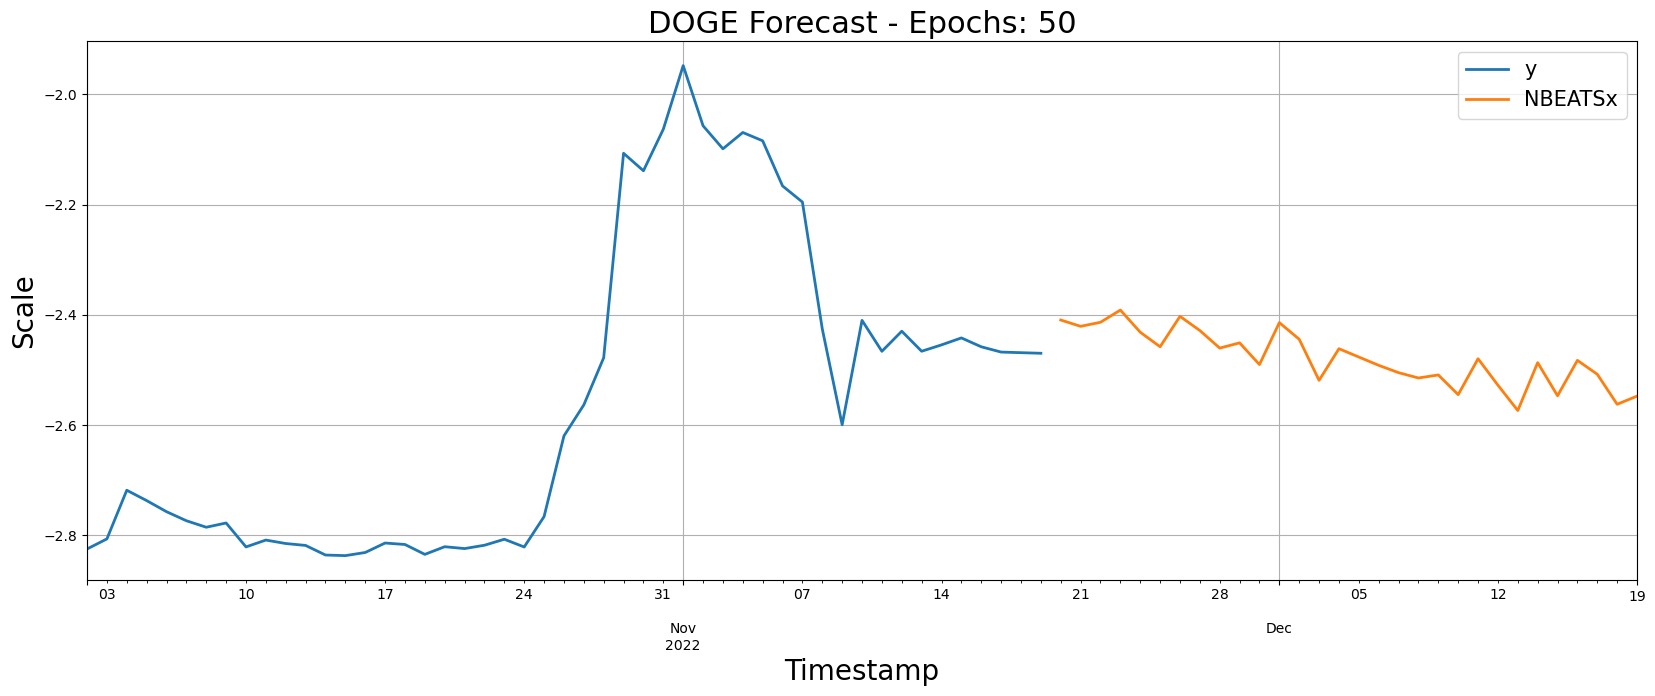

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

# Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df = plot_df[plot_df.index>'2022-10-01'] 

plot_df[[
    'y', 
    # 'RNN', 
    # 'GRU',  
    # 'LSTM',
    # 'DilatedRNN', 
    # 'MLP',
    # 'NHITS', 
    # 'NBEATS',  
    # 'NBEATSx', 
    # 'TFT', 
    currentModel,
    # 'Mix',
]].plot(ax=ax, linewidth=2)

ax.set_title(ticker + ' Forecast - Epochs: ' + str(max_epochs), fontsize=22)
ax.set_ylabel('Scale', fontsize=20)
ax.set_xlabel('Timestamp', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.savefig(imgPath + ticker, bbox_inches='tight')
